# Imports

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.exceptions import UndefinedMetricWarning

from IPython.display import clear_output


%run functions_wines.ipynb
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# Carga de datos

In [2]:
df = pd.read_csv("VinhoVerde.csv")

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


No hay datos faltantes, y todos son números, lo cuál simplificará el análisis.

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Los datos parecen tener estadísticos razonables. No obstante, algunas desviaciones demasiado altas me llaman la atención, así que haré unos boxplot para asegurarme.

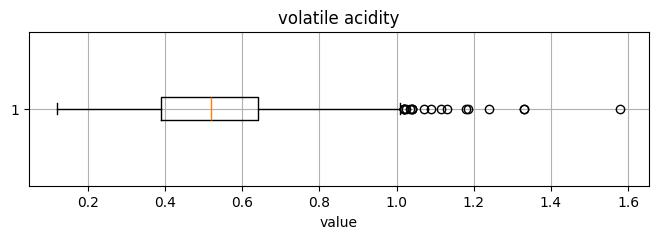

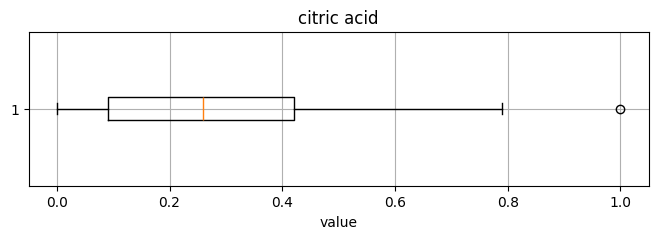

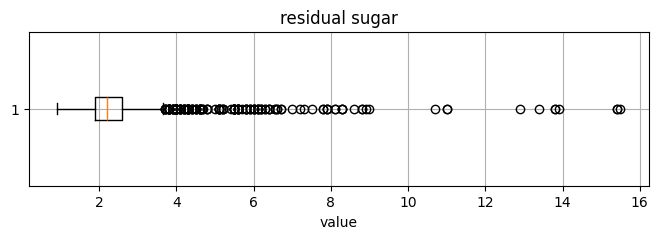

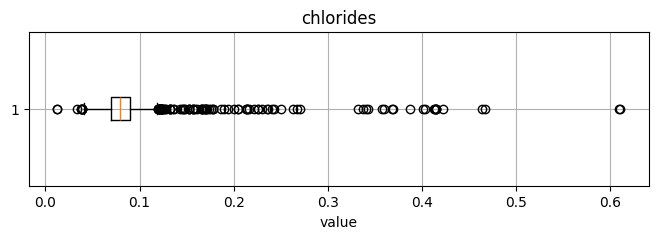

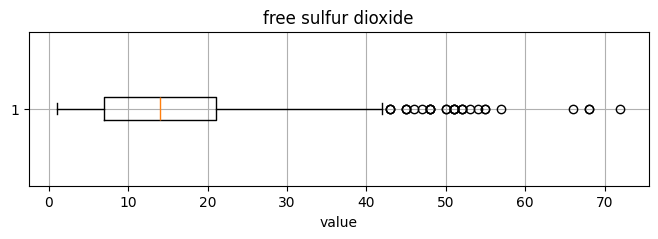

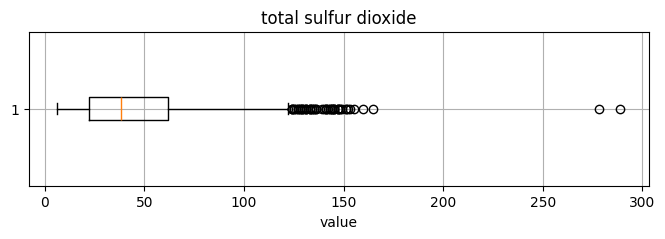

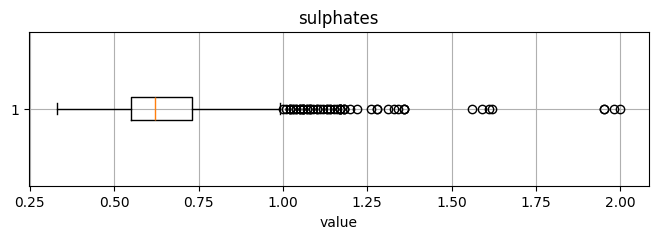

In [5]:

generate_boxplot_from_list(list(df["volatile acidity"]), "volatile acidity")
generate_boxplot_from_list(list(df["citric acid"]), "citric acid")
generate_boxplot_from_list(list(df["residual sugar"]), "residual sugar")
generate_boxplot_from_list(list(df["chlorides"]), "chlorides")
generate_boxplot_from_list(list(df["free sulfur dioxide"]), "free sulfur dioxide")
generate_boxplot_from_list(list(df["total sulfur dioxide"]), "total sulfur dioxide")
generate_boxplot_from_list(list(df["sulphates"]), "sulphates")


No veo nada extraño a primera instancia. Pero tampoco es que sepa de vinos.

Por último, veamos la distribución de la variable dependiente:

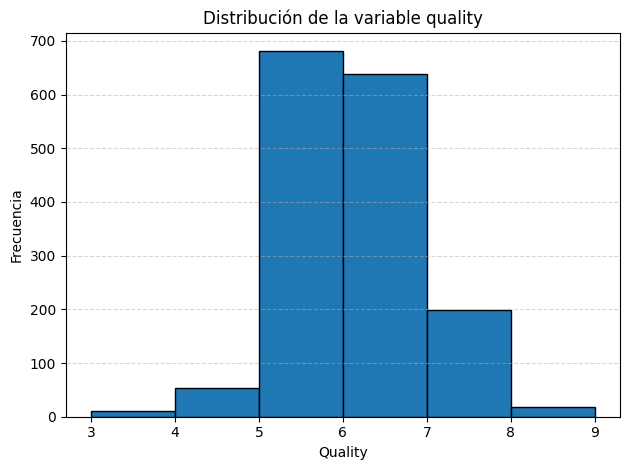

In [6]:

plt.hist(df['quality'], bins=range(int(df['quality'].min()), int(df['quality'].max()) + 2), edgecolor='black')
plt.title('Distribución de la variable quality')
plt.xlabel('Quality')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Esto quiere decir que hay un fuerte imbalance de clases. Cómo no hay suficientes datos para recortar, entonces se tendrán que agregar pesos relativos a los distintos valores de quality. Esta es una práctica habitual para el caso de las clasificaciones, pero no tanto así en el caso de las regresiones ya que las mismas son valores continuos. De todas formas, algunas librerías de Python cuentan con herramientas para ponderar la función de pérdida en caso de regresiones, así que elegiremos regresores que cuenten con eso para no tener que programarlo de cero.


# Análisis

### Correlación

/var/folders/3z/t4hm1r_x1rqdc2q4tp65rsy0gz8k2h/T/ipykernel_29391/475498112.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corrs.values, y=corrs.index, palette='coolwarm')


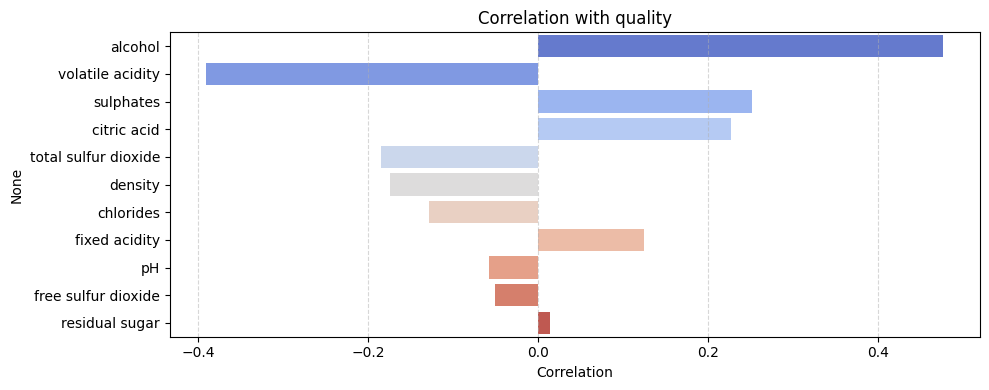

In [7]:
plot_corr_with_target(df, 'quality')

1. Alcohol es la variable más correlacionada con quality.
    * Correlación positiva fuerte (~0.45).

2. Volatile acidity tiene una fuerte correlación negativa.
    * Cuanto más alta, peor la calidad.

3. Sulphates, citric acid y total sulfur dioxide también aportan información.

4. Residual sugar, free sulfur dioxide, pH, fixed acidity tienen muy poca correlación.
    * Prácticamente no aportan señal útil por sí solos respecto a la calidad.
    * Pueden descartarse como features si se busca reducir dimensionalidad.

5. Curioso que density tenga correlación negativa
    * Quizás esté capturando ruido.

Conclusión rápida para modelado:
Podría quedarme solamente con: alcohol, volatile acidity, sulphates, citric acid y quizás total sulfur dioxide.

No obstante, cómo el volumen de datos no es muy grande, utilizaré toda la información.

### Train & test split

In [8]:

#train, test = train_test_split(df, test_size=0.3, random_state=42)
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['quality'])


X_train = train.drop(columns='quality')
y_train = train['quality']
X_test = test.drop(columns='quality')
y_test = test['quality']

### Regresión

Utilizaré un modelo simple y un modelo un poco más complejo para hacer la regresión. Cómo modelo simple elegiré la regresión lineal, y como modelo complejo el gradient boosting. 

Hay muchas formas de ir mejorando de forma iterativa los resultados. Se hará de la siguiente forma:

1. Low hanging fruit: Entrenamiento simple

2. Sampled weights: Entrenamiento con pesos relativos para contrarrestar el balance de clases

3. Grid search - cross validation: Agregamos cross validation como método de validación, y realizamos una optimización de hiperparámetros


#### Low hanging fruit:

Primero realizaré un entrenamiento sin muchas complicaciones, y lo utilizaré de benchmark para mejoras futuras.

In [9]:
y_pred_lr, y_pred_gb, rmse_lr, rmse_gb = evaluar_modelos_regresion(X_train, X_test, y_train, y_test)

RMSE logistic regression: 0.639
RMSE gradient boosting:   0.586


In [10]:
extraer_metricas(y_pred_lr, y_test, "LINEAR REGRESSION")


=== Métricas globales para LINEAR REGRESSION ===
Accuracy: 58.33 %
Precision macro:    0.463
Recall macro:       0.263
F1 macro:           0.269

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 1.000, Recall = 0.062, F1 = 0.118
Clase 5: Precision = 0.657, Recall = 0.686, F1 = 0.671
Clase 6: Precision = 0.518, Recall = 0.677, F1 = 0.587
Clase 7: Precision = 0.600, Recall = 0.150, F1 = 0.240
Clase 8: Precision = 0.000, Recall = 0.000, F1 = 0.000


El modelo LINEAR REGRESSION está clasificando con bajo accuracy, y además ignorando completamente las clases 3, 4 y 8.

In [11]:
extraer_metricas(y_pred_gb, y_test, "GRADIENT BOOSTING")


=== Métricas globales para GRADIENT BOOSTING ===
Accuracy: 62.92 %
Precision macro:    0.304
Recall macro:       0.305
F1 macro:           0.303

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 5: Precision = 0.704, Recall = 0.701, F1 = 0.703
Clase 6: Precision = 0.588, Recall = 0.693, F1 = 0.636
Clase 7: Precision = 0.531, Recall = 0.433, F1 = 0.477
Clase 8: Precision = 0.000, Recall = 0.000, F1 = 0.000


GRADIENT BOOSTING presenta una mejora, al tener mejor accuracy y contemplar la clase 8.

#### Sampled weights

Continuamos con la primera iteración del modelo: Considerar sampled weights para solventar el imbalance de clases.

In [12]:
y_pred_lr, y_pred_gb, rmse_lr, rmse_gb = evaluar_modelos_regresion(X_train, X_test, y_train, y_test, usar_pesos=True)

RMSE logistic regression: 0.877
RMSE gradient boosting:   0.636


In [13]:
extraer_metricas(y_pred_lr, y_test, "LINEAR REGRESSION")


=== Métricas globales para LINEAR REGRESSION ===
Accuracy: 45.00 %
Precision macro:    0.249
Recall macro:       0.271
F1 macro:           0.243

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.063, Recall = 0.312, F1 = 0.105
Clase 5: Precision = 0.573, Recall = 0.520, F1 = 0.545
Clase 6: Precision = 0.571, Recall = 0.396, F1 = 0.468
Clase 7: Precision = 0.444, Recall = 0.467, F1 = 0.455
Clase 8: Precision = 0.091, Recall = 0.200, F1 = 0.125


In [14]:
extraer_metricas(y_pred_gb, y_test, "GRADIENT BOOSTING")


=== Métricas globales para GRADIENT BOOSTING ===
Accuracy: 62.08 %
Precision macro:    0.399
Recall macro:       0.356
F1 macro:           0.365

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.400, Recall = 0.125, F1 = 0.190
Clase 5: Precision = 0.707, Recall = 0.711, F1 = 0.709
Clase 6: Precision = 0.573, Recall = 0.635, F1 = 0.602
Clase 7: Precision = 0.549, Recall = 0.467, F1 = 0.505
Clase 8: Precision = 0.167, Recall = 0.200, F1 = 0.182


Aquí ocurre una cosa interesante: La calidad del accuracy baja, pero el modelo comienza a ver la clase número 4 también. Esto puede verse rápidamente al observar la mejora de las métricas de precision, recall, y f1 score macro.

Consideraré que ambos modelos son mejores que su versión "low hanging fruit", y procederé con su siguiente iteración.

#### Cross validation

Para esta parte me limitaré a hacer la cross validation del gradient boosting.

In [15]:

param_grid = {
            'n_estimators': [10, 100, 200],
            'max_depth': [2, 3, 6],
            'learning_rate': [0.05, 0.1, 0.2]
        }

y_pred_gb_cv, rmse_gb_cv = entrenar_gradient_boosting_CV(X_train, X_test, y_train, y_test, param_grid)

RMSE Gradient Boosting: 0.636
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [16]:
extraer_metricas(y_pred_gb_cv, y_test, "GRADIENT BOOSTING CV")


=== Métricas globales para GRADIENT BOOSTING CV ===
Accuracy: 62.71 %
Precision macro:    0.389
Recall macro:       0.347
F1 macro:           0.351

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.333, Recall = 0.062, F1 = 0.105
Clase 5: Precision = 0.705, Recall = 0.725, F1 = 0.715
Clase 6: Precision = 0.588, Recall = 0.646, F1 = 0.615
Clase 7: Precision = 0.540, Recall = 0.450, F1 = 0.491
Clase 8: Precision = 0.167, Recall = 0.200, F1 = 0.182


La mejora no vale la pena la diferencia en costo computacional (casi 20 veces la diferencia en tiempo de ejecución). Además, el F1 score es un poco peor.

Terminemos con la parte del regresor, haciendo su matriz de confusión para el modelo que mejor se comporta.

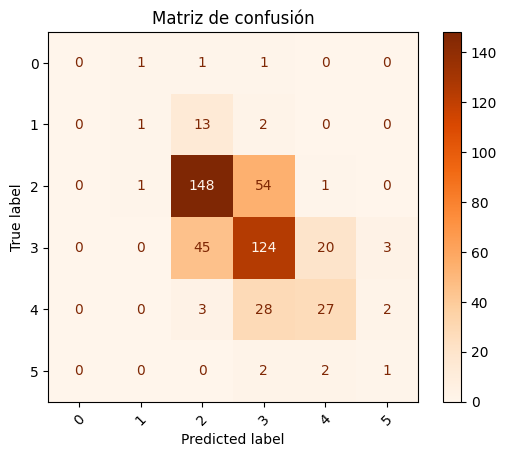

In [17]:
plot_confusion_matrix(y_pred_gb_cv, y_test)



### Clasificación

Repetiremos lo mismo de arriba pero esta vez para clasificación. Se utilizarán los clasificadores equivalentes a los regresores: Regresión logística, y Gradient Boosting Classifier.

Es de esperar que los resultados sean peores, ya que la calidad tiene una noción de ordinalidad, mientras que la clasificación no tiene en cuenta esto.

Seguiremos los pasos de la parte anterior:

1. Low hanging fruit: Entrenamiento simple.

2. Sampled weights: Esta vez para clasificación.

3. Grid Search Cross Validation 2: Más validado que nunca.

In [18]:

lr_pred, gb_pred = evaluar_modelos_clasificacion(X_train, X_test, y_train)

clear_output()


In [19]:

extraer_metricas_clasificacion(lr_pred, y_test, "LOGISTIC REGRESSION")

extraer_metricas_clasificacion(gb_pred, y_test, "GRADIENT BOOSTING")


=== Métricas globales para LOGISTIC REGRESSION ===
Accuracy: 58.54 %
Precision macro:    0.299
Recall macro:       0.255
F1 macro:           0.254

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 5: Precision = 0.648, Recall = 0.730, F1 = 0.687
Clase 6: Precision = 0.524, Recall = 0.635, F1 = 0.574
Clase 7: Precision = 0.625, Recall = 0.167, F1 = 0.263
Clase 8: Precision = 0.000, Recall = 0.000, F1 = 0.000

=== Métricas globales para GRADIENT BOOSTING ===
Accuracy: 65.42 %
Precision macro:    0.438
Recall macro:       0.353
F1 macro:           0.371

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.333, Recall = 0.062, F1 = 0.105
Clase 5: Precision = 0.705, Recall = 0.760, F1 = 0.731
Clase 6: Precision = 0.610, Recall = 0.693, F1 = 0.649
Clase 7: Precision = 0.727, Recall = 0.400, F1 = 0.516
Clase 8: Precision = 0.250, Recall = 0.200, F

Los resultados son buenos para Gradient Boosting. Tiene accuracy alto, y además observa todas las clases (menos la 3).

#### Sampled weights

In [20]:

lr_pred_weighted, gb_pred_weighted = evaluar_modelos_clasificacion(X_train, X_test, y_train, True)

clear_output()


In [21]:

extraer_metricas_clasificacion(lr_pred_weighted, y_test, "LOGISTIC REGRESSION")

extraer_metricas_clasificacion(gb_pred_weighted, y_test, "GRADIENT BOOSTING")


=== Métricas globales para LOGISTIC REGRESSION ===
Accuracy: 40.83 %
Precision macro:    0.300
Recall macro:       0.397
F1 macro:           0.276

--- Métricas por clase ---
Clase 3: Precision = 0.024, Recall = 0.333, F1 = 0.044
Clase 4: Precision = 0.083, Recall = 0.375, F1 = 0.136
Clase 5: Precision = 0.705, Recall = 0.505, F1 = 0.589
Clase 6: Precision = 0.561, Recall = 0.286, F1 = 0.379
Clase 7: Precision = 0.382, Recall = 0.483, F1 = 0.426
Clase 8: Precision = 0.043, Recall = 0.400, F1 = 0.078

=== Métricas globales para GRADIENT BOOSTING ===
Accuracy: 64.38 %
Precision macro:    0.375
Recall macro:       0.343
F1 macro:           0.354

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 5: Precision = 0.706, Recall = 0.740, F1 = 0.722
Clase 6: Precision = 0.621, Recall = 0.682, F1 = 0.650
Clase 7: Precision = 0.591, Recall = 0.433, F1 = 0.500
Clase 8: Precision = 0.333, Recall = 0.200, F

En este caso, la regresión logística empeoró en accuracy, pero mejoró en F1 score, pero quedándose muy atrás en todos los aspectos con el Gradient Boosting.

Por otro lado, el Gradient Boosting empeoró el accuracy, y empeoró en la distinción de clases (puede verse en como comenzó a ignorar la clase 4).

A priori puede parecer extraño que teniendo en cuenta los pesos sea peor, pero sto se debe a que, en clasificación, si usás class_weight='balanced', le estás diciendo al modelo:
“Prefiero equivocarme en la clase 6 antes que equivocarme en la clase 4, porque hay pocas de 4”. Esto no ocurre en regresión, ya que si una clase tiene pocos valores (ej: quality = 4), eso solo afecta estadísticamente a la predicción, no hay un "castigo" por no predecir 4.

Por lo tanto, GB sin pesos va ganando. Hagamos el gridsearch con el mismo.

(Aclaración, podría ocurrir que GB con pesos sea mejor al usar el grid search, pero no lo tendré en cuenta ya que este notebook se está yendo un poco largo).

#### Grid Search

Utilizaremos la misma grilla que para el caso de regresión.

In [22]:

param_grid = {
            'n_estimators': [10, 100, 200],
            'max_depth': [2, 3, 6],
            'learning_rate': [0.05, 0.1, 0.2]
        }


y_pred_gb_cv_clasif, rmse_gb_cv = entrenar_gradient_boosting_CV_clasificacion(X_train, X_test, y_train, y_test, param_grid)


Accuracy Gradient Boosting: 63.75 %
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [23]:
extraer_metricas(y_pred_gb_cv_clasif, y_test, "GRADIENT BOOSTING CV")


=== Métricas globales para GRADIENT BOOSTING CV ===
Accuracy: 63.75 %
Precision macro:    0.400
Recall macro:       0.338
F1 macro:           0.355

--- Métricas por clase ---
Clase 3: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 4: Precision = 0.000, Recall = 0.000, F1 = 0.000
Clase 5: Precision = 0.698, Recall = 0.735, F1 = 0.716
Clase 6: Precision = 0.607, Recall = 0.677, F1 = 0.640
Clase 7: Precision = 0.595, Recall = 0.417, F1 = 0.490
Clase 8: Precision = 0.500, Recall = 0.200, F1 = 0.286


Hagamos la matriz de confusión con el mejor GB antes de comparar la regresión con la clasificación.

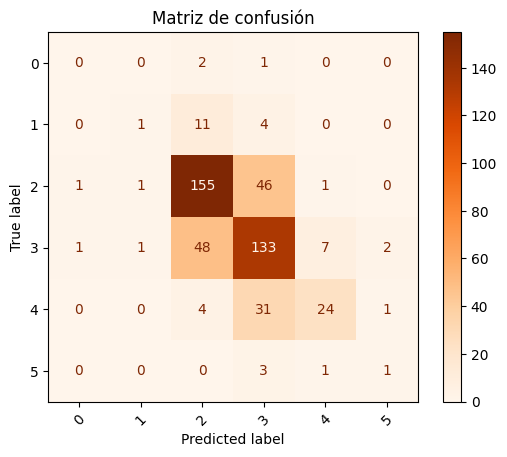

In [24]:
plot_confusion_matrix(gb_pred, y_test)


## Comparación de resultados

El modelo GRADIENT BOOSTING de __clasificación__ tiene mejor accuracy y F1 score. Esto se debe a que el modelo de regresión no está optimizado para acertar clases enteras. Está optimizado para minimizar el RMSE, y por lo tanto al llevar a cabo el redondeo empeora la calidad de su predicción.

Por lo tanto, el método de clasificación es mejor en este caso, aunque el de regresión contenga "más información" al medir la distancia de cada valor al target objetivo. No obstante, no esta información no es de interés para los productores de vino (supongo) que están acostumbrados a una medida discreta de la calidad.

Por último, hagamos un experimento final con los dos mejores resultados: Qué pasa si discretizo los vinos en 3 clases: bueno - regular - malo?

In [25]:
df['quality'] = df['quality'].apply(lambda x: 1 if x in [3, 4, 5] else 2 if x == 6 else 3)


#train, test = train_test_split(df, test_size=0.3, random_state=42)
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['quality'])


X_train = train.drop(columns='quality')
y_train = train['quality']
X_test = test.drop(columns='quality')
y_test = test['quality']


param_grid = {
            'n_estimators': [10, 100, 200],
            'max_depth': [2, 3, 6],
            'learning_rate': [0.05, 0.1, 0.2]
        }

y_pred_gb_cv, rmse_gb_cv = entrenar_gradient_boosting_CV(X_train, X_test, y_train, y_test, param_grid)

extraer_metricas(y_pred_gb_cv, y_test, "GRADIENT BOOSTING CV")


y_pred_gb_cv_clasif, rmse_gb_cv = entrenar_gradient_boosting_CV_clasificacion(X_train, X_test, y_train, y_test, param_grid)

extraer_metricas(y_pred_gb_cv_clasif, y_test, "GRADIENT BOOSTING CV CLASIFICACION")


RMSE Gradient Boosting: 0.491
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

=== Métricas globales para GRADIENT BOOSTING CV ===
Accuracy: 71.25 %
Precision macro:    0.713
Recall macro:       0.690
F1 macro:           0.699

--- Métricas por clase ---
Clase 1: Precision = 0.807, Recall = 0.731, F1 = 0.767
Clase 2: Precision = 0.629, Recall = 0.724, F1 = 0.673
Clase 3: Precision = 0.702, Recall = 0.615, F1 = 0.656
Accuracy Gradient Boosting: 73.75 %
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

=== Métricas globales para GRADIENT BOOSTING CV CLASIFICACION ===
Accuracy: 73.75 %
Precision macro:    0.721
Recall macro:       0.720
F1 macro:           0.720

--- Métricas por clase ---
Clase 1: Precision = 0.789, Recall = 0.807, F1 = 0.798
Clase 2: Precision = 0.695, Recall = 0.677, F1 = 0.686
Clase 3: Precision = 0.677, Recall = 0.677, F1 = 0.677


En este caso nuevamente ocurre que la clasificación se comporta mejor que la regresión.